# Assignment Brief: Mean-field variational inference for the Gaussian mixture model

## Deadline: December 13, 2024, 17:00 GMT

## Number of marks available: 50

In this coursework, you will use Python libraries, mainly numpy and scipy, to implement variational inference for the Gaussian mixture model.

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM64101_Assignment_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de. Example: `COM64101_Assignment_abc18de.ipynb`

C. Upload the Jupyter Notebook in B to Blackboard under the submission area before the deadline.

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already. 


### Assessment Criteria 

* Being able to implement in Python the mean-field variational inference update equations for a Gaussian mixture model.

* Being able to derive the expressions of the Evidence Lower Bound (ELBO) in the variational treatment of a Gaussian mixture model.

* Being able to implement in Python the ELBO derived. 


### Code quality and use of Python libraries
When writing your code, you will find out that there are operations that are repeated at least twice. If your code is unreadable, we may not award marks for that section. Make sure to check the following:

* Did you include Python functions to solve the question and avoid repeating code? 
* Did you comment your code to make it readable to others?

**DO NOT USE any packages other than numpy, scipy and pandas for the questions on this assignment. You are meant to write Python code from scratch. Using libraries or software packages other than numpy, scipy and pandas for the questions on this assignment will give ZERO marks. No excuse will be accepted.**

### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 10% of the mark each 24 hours the work is late after the deadline. NO late submission will be marked one week after the deadline. Please read [this link](https://wiki.cs.manchester.ac.uk/index.php/UGHandbook23:Main#Late_Submission_of_Coursework_Penalty). 

### Use of unfair means 

**Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations.** Please carefully read [what constitutes Unfair Means](https://documents.manchester.ac.uk/display.aspx?DocID=2870) if not sure. If you still have questions, please ask your Personal tutor or the Lecturers.

-----------------------------------

## Gaussian mixture models


In practice, exact Bayesian inference is usually infeasible for complex probabilistic models because the posterior distribution may not have a closed-form expression, or numerical integration for the posterior distribution is prohibitively expensive. Therefore, approximate inference is needed in such cases.

In this notebook, *Mean-Field Variational Inference (MFVI)*, a variational technique using factorised analytical approximations to the posterior distribution, is applied to a Gaussian Mixture Model (GMM).

We start by loading some basic libraries and utilities

In [1]:
# import packages
import numpy as np

from scipy.special import digamma, loggamma, gamma
from scipy.stats import multivariate_t

import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
plt.rcParams["figure.figsize"] = (6, 4)

## Dataset - Old Faithful

Gaussian mixture models can describe complex probability distributions over vectors of random variables and they are typically used for clustering. 

We will use the **Old Faithful** dataset in this notebook. It is a classic statistical dataset that records the eruptions of the Old Faithful geyser in Yellowstone National Park. It includes 272 observations, each with two main features:

1. **Eruption Duration (eruptions)**: The length of each eruption in minutes.
2. **Waiting Time (waiting)**: The time interval between successive eruptions in minutes.

We want to explore the relationship between eruption duration and waiting time in this dataset.

dataset shape: N=272, D=2.


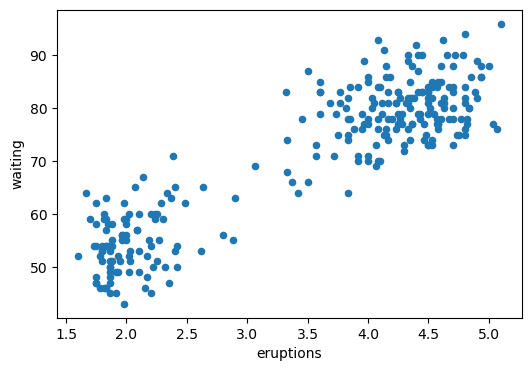

In [2]:
# load dataset
url = ("https://gist.githubusercontent.com/curran/"
       "4b59d1046d9e66f2787780ad51a1cd87/raw/"
       "9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv")
old_faithful = pd.read_table(url)
old_faithful.plot.scatter(x="eruptions", y="waiting")

X = old_faithful.values
N, D = X.shape
print(f"dataset shape: N={N}, D={D}.")

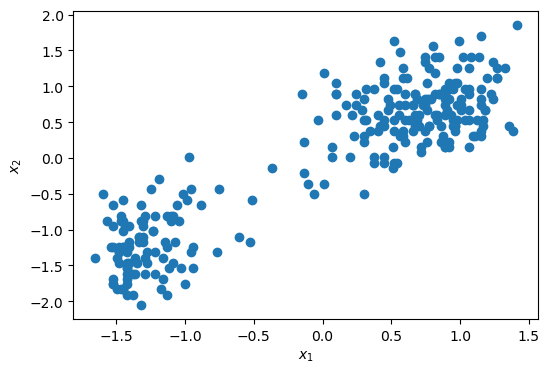

In [3]:
# standardise the dataset
mean = X.mean(axis=0, keepdims=True)
std = X.std(axis=0, keepdims=True)
X = (X - mean) / std

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:, 0], X[:, 1])

## Model - GMM with parameter priors

Assume a dataset $\mathbf{X} = \{\mathbf{x}_n\}_{n=1}^N\in\mathbb{R}^{N\times D}$ with i.i.d. observations from a GMM,

$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}\left(\mathbf{x} \vert \boldsymbol{\mu}_k, \boldsymbol{\Lambda}^{-1}_k\right),
$$
where $\boldsymbol{\pi} = \{\pi_k\}_{k=1}^K$ are mixing coefficients, $\boldsymbol{\mu}= \{\boldsymbol{\mu}_k\}_{k=1}^K$ and $\boldsymbol{\Lambda}= \{\boldsymbol{\Lambda}_k\}_{k=1}^K$ represent the means and the precision matrices, respectively. For $p(\mathbf{x})$ to be a valid probability density function, the mixing coefficients must follow $\pi_k\ge 0$ and $\sum_{k=1}^K \pi_k=1$.

By introducing 1-of-K binary vectors $\mathbf{Z}=\{\mathbf{z}_n\}_{n=1}^{N}\in\mathbb{R}^{N\times K}$, the GMM can be expressed as

\begin{aligned}
p(\mathbf{Z}\vert \boldsymbol{\pi})
& =\prod_{n=1}^N p(\mathbf{z}_n\vert \boldsymbol{\pi}) = \prod_{n=1}^N\prod_{k=1}^K{\pi_k}^{z_{nk}}, \\
p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\mu},\boldsymbol{\Lambda})
&= \prod_{n=1}^N p(\mathbf{x}_n\vert\mathbf{z}_n, \boldsymbol{\mu},\boldsymbol{\Lambda})
=\prod_{n=1}^N\prod_{k=1}^K \mathscr{N}\left(\mathbf{x}_n \vert \boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k^{-1}\right)^{z_{nk}}.
\end{aligned}

We can use a maximum-likelihood approach to find point estimates for the parameters $\boldsymbol{\pi} = \{\pi_k\}_{k=1}^K$, $\boldsymbol{\mu}= \{\boldsymbol{\mu}_k\}_{k=1}^K$ and $\boldsymbol{\Lambda}= \{\boldsymbol{\Lambda}_k\}_{k=1}^K$. Since there is hidden information for each $\mathbf{x}_n$, this is, we do not know apriori to which component of the mixture it belongs to, we can use the [*Expectation-Maximization* (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is a generalization of the maximum-likelihood criterion for models with hidden variables.

## Prior distributions

Rather than using an EM algorithm, we will follow a Bayesian treatment of the GMM. 

We start by introducing conjugate prior distributions over the model parameters $\boldsymbol{\pi}$, $\boldsymbol{\mu}$ and $\boldsymbol{\Lambda}$:

$$
p(\boldsymbol{\pi}) = \text{Dir}(\boldsymbol{\pi}\vert\boldsymbol{\alpha}_0)\propto \prod_{k=1}^K \pi_{k}^{\alpha_0 -1},
$$

$$
p(\boldsymbol{\mu}\vert\boldsymbol{\Lambda}) = \prod_{k=1}^Kp(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k) =
\prod_{k=1}^K \mathcal{N}\left(\boldsymbol{\mu}_k\vert\mathbf{m}_0, (\beta_0\boldsymbol{\Lambda}_k)^{-1}\right),
$$

$$
p(\boldsymbol{\Lambda}) = \prod_{k=1}^K p(\boldsymbol{\Lambda}_k) =\prod_{k=1}^K \mathcal{W}(\boldsymbol{\Lambda}_k\vert\mathbf{W}_0, \nu_0),
$$
where $\mathcal{N}$ and $\mathcal{W}$ represent the multivariate normal distribution and the Wishart distribution (the Wishart distribution was studied in the first two weeks of the module. It was referred to as $\text{Wi}$, but we will use $\mathcal{W}$ in this notebook).

We define a Python class for these conjugate priors for the parameters in the GMM

In [5]:
class GMMPrior:
  """ GMM with prior distribution """
  def __init__(self, K, D, alpha_0, m_0, beta_0, W_0, nu_0):
    self.K = K                                    # number of clusters
    self.D = D                                    # data dims
    self.p_dists = {                              # priors over params
        'pi': {'alpha': np.asarray(alpha_0)},
        'mu_Lam': {'m': np.asarray(m_0), 'beta': np.asarray(beta_0)},
        'Lam': {'W': np.asarray(W_0), 'nu': np.asarray(nu_0)}
    }

K, D = 6, 2

# params for p(π)
alpha_0 = 1.              # > 0, same params for each k

# params for p(μ|Λ)
m_0 = X.mean(axis=0)      # [D], shared across k
beta_0 = 1.

# params for p(Λ)
W_0 = np.eye(D)           # [D, D], shared across k
nu_0 = D + 1              # > D-1, shared

# initialise model
gmm_p = GMMPrior(K, D, alpha_0, m_0, beta_0, W_0, nu_0)

## Full joint distribution


The full joint distribution of all random variables factorises as follows:

$$
p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})
= p(\mathbf{X} \vert \mathbf{Z}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) p(\mathbf{Z} \vert\boldsymbol{\pi}) p(\boldsymbol{\pi})  p(\boldsymbol{\mu} \vert \boldsymbol{\Lambda}) p(\boldsymbol{\Lambda}).
$$

## Computing the posterior distribution using mean-field variational inference

For MFVI, it is possible to analytically compute expressions for the posterior distributions over each of the parameters of the model. 

We consider that the full posterior distribution $q(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})$ over the hidden variables and $\mathbf{Z}$ and parameters $\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}$ factorises as:

$$
q(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) = q(\mathbf{Z}) q(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})
$$

Variational inference maximises the following lower bound to find an approximation for the true posterior distribution $p(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}\vert\mathbf{X})$:

$$
L[q]=\int q(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})\ln\left\{\frac{p(\mathbf{X},\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})}{q(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})}\right\}.
$$

We then need to find the optimal functional solution for $q(\mathbf{Z})$ and $q(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})$.

**Optimal form for $q(\mathbf{Z})$**

\begin{aligned}
L[q] & = \int q(\mathbf{Z})\left\{q(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})\int\ln p(\mathbf{X},\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) d\boldsymbol{\pi}d\boldsymbol{\mu}d\boldsymbol{\Lambda}\right\} d\mathbf{Z} - \int q(\mathbf{Z})\ln q(\mathbf{Z})d\mathbf{Z} + const \\
&= -\mathrm{KL}\left[q(\mathbf{Z})\vert\vert \mathbb{E}_{q(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})} \left[ \ln p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) \right]\right].
\end{aligned}

Hence, the optimal $q^*(\mathbf{Z})$ is given by:
\begin{aligned}
\ln q^*(\mathbf{Z})
&= \mathbb{E}_{q(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})} \left[ \ln p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) \right] + const \\
&= \mathbb{E}_{q(\boldsymbol{\pi})}\left[\ln p(\mathbf{Z}\vert \boldsymbol{\pi})\right]
+ \mathbb{E}_{q(\boldsymbol{\mu},\boldsymbol{\Lambda})}\left[\ln p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\mu},\boldsymbol{\Lambda})\right] + const \\
&= \sum_{n=1}^N\sum_{k=1}^K z_{nk}\ln\rho_{nk} + const,
\end{aligned}
where we define
$$
\ln\rho_{nk} = \mathbb{E}_{q(\pi_k)}[\ln\pi_k]
+ \frac{1}{2}\mathbb{E}_{q({\boldsymbol{\Lambda}}_k)}\left[\ln|\Lambda_k|\right] - \frac{1}{2}\mathbb{E}_{q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)}\left[(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\right] - \frac{D}{2}\ln(2\pi).
$$

These expected values will be computed later on. 

We can conclude that $q^*(\mathbf{Z})$ is a factorised categorical distribution from the functional form of $\ln q^*(\mathbf{Z})$, i.e., $q^*(\mathbf{Z})\propto\prod_{n=1}^N\prod_{k=1}^K\rho_{nk}^{z_{nk}}$. After normalizing the expression, we obtain
$$
q^*(\mathbf{Z})=\prod_{n=1}^N\prod_{k=1}^K r_{nk}^{z_{nk}}, \quad
r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^K\rho_{nj}}.
$$
$r_{nk}$ can be interpreted as the *responsibility* that component $k$ takes for "explaining" the $n$-th observation.

**Optimal form for $q(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})$**

Similarly, the optimal $q^*(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})$ takes the form
\begin{aligned}
\ln q^*(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})
&= \mathbb{E}_{q(\mathbf{Z})} \left[ \ln p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) \right] + const \\
&= \ln p(\boldsymbol{\pi}) + \ln p(\boldsymbol{\mu},\boldsymbol{\Lambda}) + \mathbb{E}_{q(\mathbf{Z})}\left[\ln p(\mathbf{Z}\vert\boldsymbol{\pi}) + \ln p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\mu},\boldsymbol{\Lambda})\right] + const\\
&= \left\{\ln p(\boldsymbol{\pi}) + \mathbb{E}[\ln p(\mathbf{Z}\vert\boldsymbol{\pi})]\right\} + \left\{\ln p(\boldsymbol{\mu},\boldsymbol{\Lambda}) + \mathbb{E}_{q(\mathbf{Z})}\left[\ln p(\mathbf{X}\vert\mathbf{Z},\boldsymbol{\mu},\boldsymbol{\Lambda})\right]\right\} + const.
\end{aligned}
The above expression implies that the variational posterior leads to factorisation
$$
q^*(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) =
q^*(\boldsymbol{\pi})\prod_{k=1}^Kq^*(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k).
$$

**Optimal form for $q(\boldsymbol{\pi})$**

Specifically, the variational distribution over $\boldsymbol{\pi}$ satisfies
\begin{aligned}
\ln q^*(\boldsymbol{\pi})
&= \ln p(\boldsymbol{\pi}) + \mathbb{E}[\ln p(\mathbf{Z}\vert\boldsymbol{\pi})]\\
& = (\alpha_0 - 1) \sum_{k=1}^{K} \ln \pi_k + \sum_{k=1}^{K} \sum_{n=1}^{N} r_{nk} \ln \pi_k + const.
\end{aligned}
We recognise $q^*(\boldsymbol{\pi})$ as a Dirichlet distribution
$q^*(\boldsymbol{\pi})=\mathrm{Dir}(\boldsymbol{\pi}\vert\boldsymbol{\alpha})$, where
$\boldsymbol{\alpha}$ has components $\alpha_k$ given by
$$\boldsymbol\alpha_k = \alpha_0 + \sum_{n=1}^N r_{nk}, \ N_k=\sum_{n=1}^N r_{nk}.$$
We use $N_k$ to denote the effective number of points assigned to cluster $k$.

**Optimal form for $q(\boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k)$** 

The variational posterior over $\boldsymbol{\mu}_k$ and $\boldsymbol{\Lambda}_k$ satisfies

\begin{aligned}
\ln q^*(\boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k)
&= \ln\mathcal{N}\left(\boldsymbol{\mu}_k\vert\mathbf{m}_0, (\beta_0\boldsymbol{\Lambda}_k)^{-1}\right) + \ln\mathcal{W}(\boldsymbol{\Lambda}_k\vert\mathbf{W}_0, \nu_0)
+ \sum_{n=1}^{N}\mathbb{E}[z_{nk}]\ln\mathcal{N}(\mathbf{x}_n\vert\boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k^{-1}) + const \\
&= -\frac{\beta_0}{2}(\boldsymbol{\mu}_k - \mathbf{m}_0)^{\top}\boldsymbol{\Lambda}_k(\boldsymbol{\mu}_k - \mathbf{m}_0) + \frac{1}{2} \ln |\boldsymbol{\Lambda_k}| - \frac{1}{2} \operatorname{Tr}(\boldsymbol{\Lambda}_k\mathbf{W}_0^{-1})
+ \frac{(\nu_0 - D - 1)}{2} \ln |\boldsymbol{\Lambda}_k| - \frac{1}{2} \sum_{n=1}^{N} \mathbb{E}[z_{nk}] (\mathbf{x}_n -\boldsymbol{\mu}_k)^{\top} \boldsymbol{\Lambda}_k(\mathbf{x}_n -\boldsymbol{\mu}_k)
+ \frac{1}{2} \left( \sum_{n=1}^{N} \mathbb{E}[z_{nk}] \right) \ln |\boldsymbol{\Lambda}_k| + const.
\end{aligned}

Let us first of all identify the distribution for $\boldsymbol{\mu}_k$:
\begin{aligned}
\ln q^*(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)
&= -\frac{1}{2}\boldsymbol{\mu}_k^{\top} \left[ \beta_0 + \sum_{n=1}^{N} \mathbb{E}[z_{nk}] \right]\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^{\top}\boldsymbol{\Lambda}_k \left[ \beta_0 \mathbf{m}_0 + \sum_{n=1}^{N} \mathbb{E}[z_{nk}]\mathbf{x}_n\right] + const \\
&= -\frac{1}{2}\boldsymbol{\mu}_k^{\top} \left[ \beta_0 + N_k \right]\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^{\top} \boldsymbol{\Lambda}_k \left[ \beta_0 \mathbf{m}_0 + N_k \bar{\mathbf{x}}_k \right] + const,
\end{aligned}
where
$
\boldsymbol{\bar{\mathbf{x}}}_k=\frac{1}{N_k}\sum_{n=1}^Nr_{nk} \mathbf{x}_n.
$
Therefore, $q^*(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)$ is a Gaussian distribution
\begin{aligned}
q^*(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)
= \mathscr{N}\left(\boldsymbol{\mu}_k\vert\mathbf{m}_k, (\beta_k\boldsymbol{\Lambda}_k)^{-1}\right), \\
\mathbf{m}_k = \frac{1}{\beta_k} (\beta_0 \mathbf{m}_0 + N_k \bar{\mathbf{x}}_k), \ \ \beta_k = \beta_0 + N_k.
\end{aligned}

Next, we determine the form of $q^*(\boldsymbol{\Lambda}_k)$ by making use of the relation

\begin{aligned}
\ln q^*(\boldsymbol{\Lambda}_k)
&= \ln q^*(\boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k) - \ln q^*(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)\\
&= -\frac{\beta_0}{2} (\boldsymbol{\mu}_k - \mathbf{m}_0)^{\top}\boldsymbol{\Lambda}_k (\boldsymbol{\mu}_k - \mathbf{m}_0) + \frac{\nu_0 - D - 1}{2} \ln |\boldsymbol{\Lambda_k}\vert - \frac{1}{2}\operatorname{Tr}(\boldsymbol{\Lambda}_k \mathbf{W}_0^{-1}) -\frac{1}{2}\sum_{n=1}^N\mathbb{E}[z_{nk}](\mathbf{x}_n-\boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n-\boldsymbol{\mu}_k)
+ \frac{1}{2} \left(\sum_{n=1}^{N} \mathbb{E}[z_{nk}]\right) \ln |\boldsymbol{\Lambda}_k| + \frac{\beta_k}{2}(\boldsymbol{\mu}_k - \mathbf{m}_k)^{\top} \boldsymbol{\Lambda}_k(\boldsymbol{\mu}_k - \mathbf{m}_k) + const \\
&= \frac{\nu_k - D - 1}{2} \ln |\boldsymbol{\Lambda}_k| - \frac{1}{2} \operatorname{Tr}(\boldsymbol{\Lambda}_k \mathbf{W}_k^{-1}) + const.
\end{aligned}
Here we have defined
\begin{aligned}
\mathbf{W}_k^{-1}
&= \mathbf{W}_0^{-1} + \beta_0 (\boldsymbol{\mu}_k - \mathbf{m}_0)(\boldsymbol{\mu}_k - \mathbf{m}_0)^{\top} + \sum_{n=1}^{N} \mathbb{E}[z_{nk}] (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^{\top},\\
&= \mathbf{W}_0^{-1} + N_k \mathbf{S}_k + \frac{\beta_0 N_k}{\beta_0 + N_k} (\bar{\mathbf{x}}_k - \mathbf{m}_0)(\bar{\mathbf{x}}_k - \mathbf{m}_0)^{\top} \\
\nu_k & = \nu_0 + \sum_{n=1}^{N} \mathbb{E}[z_{nk}] = \nu_0 + N_k,
\end{aligned}
where
$$
\mathbf{S}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk}
\left(\mathbf{x}_n - \boldsymbol{\bar{\mathbf{x}}}_k\right)\left({\bf x}_n - \boldsymbol{\bar{\bf x}}_k\right)^\top.
$$

**Optimal form for $q(\mathbf{Z})$**

Provided the aforementioned functional form of $q^*(\boldsymbol{\pi})$ and $q^*(\boldsymbol{\mu},\boldsymbol{\Lambda})$, we can compute $q^*(\mathbf{Z})$ now.
Recall that the responsibility $r_{nk}$ is given by
$$r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^K\rho_{nj}},$$
where
$$
\ln\rho_{nk} = \ln\widetilde{\pi}_k  
+ \frac{1}{2}\ln\widetilde{\Lambda}_k - \frac{1}{2}\mathbb{E}_{q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)}\left[(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\right] - \frac{D}{2}\ln(2\pi)
$$

$$
\ln\widetilde{\pi}_k = \mathbb{E}_{q(\pi_k)}[\ln\pi_k] = \psi(\alpha_k) - \psi(\widehat{\alpha}), \
\psi(x) = \frac{d\Gamma(x)}{dx},\
\widehat{\alpha} = \sum_{k=1}^K\alpha_k,
$$

$$
\ln\widetilde{\Lambda}_k=\mathbb{E}_{q(\boldsymbol{\Lambda}_k)}\left[\ln|\boldsymbol{\Lambda}_k|\right]
= \sum_{i=1}^D\psi\left(\frac{\nu_k + 1 - i}{2}\right)
+ \ln|\mathbf{W}_k| + D\ln 2,
$$

$$
\mathbb{E}_{q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)}
\left[(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\right]
= \nu_k(\mathbf{x}_n - \mathbf{m}_k)^\top \mathbf{W}_k(\mathbf{x}_n - \mathbf{m}_k) + D\beta^{-1}_k.
$$

In $\ln\widetilde{\pi}_k$ and $\ln\widetilde{\Lambda}_k$, we use the proporties of the Dirichlet distribution and the Wishart distribution, respectively. The last expression is derived from an integration with respect to the variational posterior distribution $q^*(\boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k) = q^*(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)q^*(\boldsymbol{\Lambda}_k)$. Thus, we have

\begin{aligned}
\mathbb{E}_{q(\boldsymbol{\mu}_k, \boldsymbol{\Lambda}_k)}\left[ (\mathbf{x}_n - \boldsymbol{\mu}_k)^{\top}\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k) \right]
&= \iint\operatorname{Tr}\left\{ \boldsymbol{\Lambda}_k (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^{\top}\right\}q^*(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)q^*(\boldsymbol{\Lambda}_k)d\boldsymbol{\mu}_k d\boldsymbol{\Lambda}_k \\
& = \int\operatorname{Tr}\left\{\boldsymbol{\Lambda}_k\left[(\mathbf{x}_n - \mathbf{m}_k)(\mathbf{x}_n - \mathbf{m}_k)^{\top} + \beta_k^{-1}\boldsymbol{\Lambda}_k^{-1}\right] \right\} q^*(\boldsymbol{\Lambda}_k)d\boldsymbol{\Lambda}_k \\
&= \int\left\{(\mathbf{x}_n - \mathbf{m}_k)^{\top}\boldsymbol{\Lambda}_k(\mathbf{x}_n - \mathbf{m}_k) + D \beta_k^{-1} \right\} q^*(\boldsymbol{\Lambda}_k) d\boldsymbol{\Lambda}_k \\
&= D \beta_k^{-1} + \nu_k (\mathbf{x}_n - \mathbf{m}_k)^{\top} \mathbf{W}_k (\mathbf{x}_n - \mathbf{m}_k),
\end{aligned}
where we use te standard result for the expectation under a Wishart distribution, i.e., $\mathbb{E}[\boldsymbol{\Lambda}_k]=\nu_k\mathbf{W}_k$.


### Summary of the variational distributions

To summarize, the variational posterior takes the following form:

$$q^*(\mathbf{Z},\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Lambda})
=q^*(\mathbf{Z})q^*(\boldsymbol{\pi})q^*(\boldsymbol{\mu},\boldsymbol{\Lambda}),$$
where
$$q^*(\mathbf{Z})=\prod_{n=1}^N\prod_{k=1}^K r_{nk}^{z_{nk}}
\tag{1}$$
$$
q^*(\boldsymbol{\pi})=\mathrm{Dir}(\boldsymbol{\pi}\vert\boldsymbol{\alpha})
\tag{2}
$$
$$
q^*(\boldsymbol{\mu},\boldsymbol{\Lambda})
=\prod_{k=1}^Kq^*(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)
=\prod_{k=1}^K\mathscr{N}\left(\boldsymbol{\mu}_k\vert\mathbf{m}_k, (\beta_k\boldsymbol{\Lambda}_k)^{-1}\right)
\mathscr{W}\left(\boldsymbol{\Lambda}_k\vert\mathbf{W}_k,\nu_k\right)
\tag{3}
$$

---

+ **In Eq.$(1)$**, the responsibility $r_{nk}$ is given by
$$r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^K\rho_{nj}}$$

$$
\ln\rho_{nk} = \ln\widetilde{\pi}_k  
+ \frac{1}{2}\ln\widetilde{\Lambda}_k - \frac{1}{2}\mathbb{E}_{q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)}\left[(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\right] - \frac{D}{2}\ln(2\pi)
$$

$$
\ln\widetilde{\pi}_k = \mathbb{E}_{q(\pi_k)}[\ln\pi_k] = \psi(\alpha_k) - \psi(\widehat{\alpha}), \
\psi(x) = \frac{d\Gamma(x)}{dx},\
\widehat{\alpha} = \sum_{k=1}^K\alpha_k,
$$

$$
\ln\widetilde{\Lambda}_k=\mathbb{E}_{q(\boldsymbol{{\Lambda}}_k)}\left[\ln|\Lambda_k|\right]
= \sum_{i=1}^D\psi\left(\frac{\nu_k + 1 - i}{2}\right)
+ \ln|\mathbf{W}_k| + D\ln 2,
$$

$$
\mathbb{E}_{\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k}
\left[(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\right]
= \nu_k(\mathbf{x}_n - \mathbf{m}_k)^\top \mathbf{W}_k(\mathbf{x}_n - \mathbf{m}_k) + D\beta^{-1}_k.
$$

---

+ For notation simplicity, we define three statistics of the observed dataset evaluated with respect to the responsibilities

$$N_k = \sum_{n=1}^N r_{nk}, \tag{4}$$
$$
\boldsymbol{\bar{\mathbf{x}}}_k=\frac{1}{N_k}\sum_{n=1}^Nr_{nk} \mathbf{x}_n,\tag{5}
$$
$$
\mathbf{S}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk}
\left(\mathbf{x}_n - \boldsymbol{\bar{\mathbf{x}}}_k\right)\left({\bf x}_n - \boldsymbol{\bar{\bf x}}_k\right)^\top. \tag{6}
$$

---
+ **In Eq.$(2)$**, $\boldsymbol{\alpha}$ has components $\alpha_k$ given by
$$\boldsymbol\alpha_k = \alpha_0 + N_k$$

---
+ **In Eq.$(3)$**,
$$\beta_k = \beta_0 + N_k$$
$$\mathbf{m}_k = \frac{1}{\beta_k}(\beta_0\mathbf{m}_0 + N_k\boldsymbol{\bar{\mathbf{x}}}_k)$$
$$
\mathbf{W}_k^{-1} = \mathbf{W}^{-1}_0 + N_k\mathbf{S}_k
+ \frac{\beta_0N_k}{\beta_0 + N_k}\left(\boldsymbol{\bar{\mathbf{x}}}_k - \mathbf{m}_0\right)\left(\boldsymbol{\bar{\mathbf{x}}}_k - \mathbf{m}_0\right)^\top
$$
$$\nu_k = \nu_0 + N_k$$


In [6]:
# set up variational distributions
class VariationalGMM:
  """ GMM equipped with mean-field variational distribution """
  def __init__(self, K, D, priors, alpha_k, m_k, beta_k, W_k, nu_k):
    self.K, self.D = K, D
    self.p_dists = priors
    self.q_dists = {
        'pi': {'alpha': np.asarray(alpha_k)},
        'mu_Lam': {'m': np.asarray(m_k), 'beta': np.asarray(beta_k)},
        'Lam': {'W': np.asarray(W_k), 'nu': np.asarray(nu_k)}
    }
    self.r_nk = None
    self.cache = {}                      # cache intermediate results

K, D = 6, 2

# params for q(π)
alpha_k = np.ones(K)                     # [K]

# params for q(μ|Λ)
m_k = np.tile(X.mean(axis=0), (K, 1))    # [K, D]
m_k = m_k + np.random.randn(*m_k.shape)*0.1
beta_k = np.ones(K)                      # [K]

# params for q(Λ)
W_k = np.tile(np.eye(D), (K,1,1))        # [K, D, D]
nu_k = np.ones(K) * (D + 1)              # [K]

# initialise model
gmm_q = VariationalGMM(K, D, gmm_p.p_dists, alpha_k, m_k, beta_k, W_k, nu_k)

## Prediction

For a new variable $\widehat{\mathbf{x}}$, the approximate predictive density is given by marginalising out $\boldsymbol{\pi},\boldsymbol{\mu}$ and $\boldsymbol{\Lambda}$:

\begin{aligned}
p(\widehat{\mathbf{x}}\vert\mathbf{X})
&\approx  \sum_{k=1}^K \iiint \pi_k\mathcal{N}\left(\widehat{\mathbf{x}}\vert\boldsymbol{\mu}_k,\boldsymbol{\Lambda}^{-1}_k\right)q(\boldsymbol{\pi})q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)d\boldsymbol{\pi}d\boldsymbol{\mu}_kd\boldsymbol{\Lambda}_k \\
&= \sum_{k=1}^K\iint\left\{\int\pi_k q(\boldsymbol{\pi})d\boldsymbol{\pi}\right\}\mathcal{N}\left(\widehat{\mathbf{x}}\vert\boldsymbol{\mu}_k,\boldsymbol{\Lambda}^{-1}_k\right)q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)d\boldsymbol{\mu}_kd\boldsymbol{\Lambda}_k\\
&= \sum_{k=1}^K\frac{\alpha_k}{\widehat{\alpha}}\int\left\{\int\mathcal{N}\left(\widehat{\mathbf{x}}\vert\boldsymbol{\mu}_k,\boldsymbol{\Lambda}^{-1}_k\right)q(\boldsymbol{\mu}_k\vert\boldsymbol{\Lambda}_k)d\boldsymbol{\mu}_k\right\}q(\boldsymbol{\Lambda}_k)d\boldsymbol{\Lambda}_k\\
&= \sum_{k=1}^K\frac{\alpha_k}{\widehat{\alpha}}\int\mathcal{N}\left(\widehat{\mathbf{x}}\vert\mathbf{m}_k,(1 + \beta^{-1}_k)\boldsymbol{\Lambda}_k^{-1}\right)q(\boldsymbol{\Lambda}_k)d\boldsymbol{\Lambda}_k,
\end{aligned}
where $\widehat{\alpha}=\sum_{k=1}^K\alpha_k$. Since the Wishart distribution is the conjugate prior for the precision of a Gaussian, we can further derive
\begin{aligned}
\int\mathcal{N}\left(\widehat{\mathbf{x}}\vert\mathbf{m}_k,(1 + \beta^{-1}_k)\boldsymbol{\Lambda}_k^{-1}\right)q(\boldsymbol{\Lambda}_k)d\boldsymbol{\Lambda}_k
&\propto \int |\boldsymbol{\Lambda}_k|^{\frac{1}{2} + \frac{\nu_k - D - 1}{2}} \exp \left\{ -\frac{1}{2 (1 + \beta_k^{-1})} \operatorname{Tr} \left[ \boldsymbol{\Lambda}_k (\widehat{\mathbf{x}} - \mathbf{m}_k)(\widehat{\mathbf{x}} - \mathbf{m}_k)^\top \right] - \frac{1}{2} \operatorname{Tr} \left[ \boldsymbol{\Lambda}_k \mathbf{W}_k^{-1} \right] \right\} \, d\boldsymbol{\Lambda}_k \\
&\propto \Big|\mathbf{W}^{-1}+\frac{(\widehat{\mathbf{x}}-\mathbf{m}_k)(\widehat{\mathbf{x}}-\mathbf{m}_k)^\top}{1+\beta_k^{-1}}\Big|^{-\frac{\nu_k+1}{2}}
\int\mathcal{W}\left(\boldsymbol{\Lambda}_k\vert\left[\mathbf{W}^{-1}+\frac{(\widehat{\mathbf{x}}-\mathbf{m}_k)(\widehat{\mathbf{x}}-\mathbf{m}_k)^\top}{1+\beta_k^{-1}}\right]^{-1}, \nu_k+1\right)d\boldsymbol{\Lambda}_k \\
&\propto \Big|\mathbf{W}^{-1}+\frac{(\widehat{\mathbf{x}}-\mathbf{m}_k)(\widehat{\mathbf{x}}-\mathbf{m}_k)^\top}{1+\beta_k^{-1}}\Big|^{-\frac{\nu_k+1}{2}}\\
&\propto \left\{ 1 + \frac{1}{1 + \beta_k^{-1}} (\widehat{\mathbf{x}} - \mathbf{m}_k)^{\top} \mathbf{W}_k (\widehat{\mathbf{x}} - \mathbf{m}_k) \right\}^{-(\nu_k + 1)/2}.
\end{aligned}
We recognise this result as Student's t-distribution
where the precision is given by
$$
\mathbf{L}_k=\frac{(\nu_k+1-D)\beta_k}{1+\beta_k}\mathbf{W}_k.
$$
In conclusion, the predictive distribution is a mixture of Student's t-distributions:
$$
p(\widehat{\mathbf{x}}\vert\mathbf{X})\approx\frac{1}{\widehat{\alpha}}\sum_{k=1}^K\alpha_k\mathrm{St}\left(\widehat{\mathbf{x}}\vert\mathbf{m}_k,\mathbf{L}_k,\nu_k+1-D\right). \\
$$

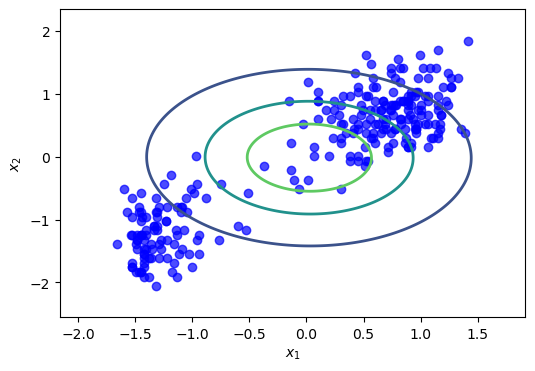

In [7]:
def plot_mixtures(X, model, step=0.01, levels=4):
  # alpha
  alpha_k = model.q_dists['pi']['alpha']
  alpha_hat = model.q_dists['pi']['alpha'].sum()

  # m_k & L_k
  m_k = model.q_dists['mu_Lam']['m']
  W_k = model.q_dists['Lam']['W']
  beta_k = model.q_dists['mu_Lam']['beta']
  v_1_D = (model.q_dists['Lam']['nu'] + 1 - model.D)
  L_k = v_1_D * beta_k / (1 + beta_k)
  L_k = L_k[..., None, None] * W_k
  Sigma_k = np.linalg.inv(L_k)

  # Plot
  x0, y0 = X.min(axis=0) - 0.5
  x1, y1 = X.max(axis=0) + 0.5
  xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
  x = np.array([xx.ravel(), yy.ravel()]).T

  pdf = 0
  for alpha, m, Sigma, df in zip(alpha_k, m_k, Sigma_k, v_1_D):
    pdf += alpha / alpha_hat * multivariate_t(m, Sigma, df=df).pdf(x).reshape(*xx.shape)

  plt.contour(xx, yy, pdf, levels=levels, linewidths=2)

  if model.r_nk is None:
    plt.scatter(X[:, 0], X[:, 1], alpha=0.7, color='b')
  else:
    plt.scatter(X[:, 0], X[:, 1], alpha=0.7, c=model.r_nk.argmax(axis=1), cmap="viridis")
  plt.xlim(x0, x1)
  plt.ylim(y0, y1)

  plt.xlabel(r'$x_1$')
  plt.ylabel(r'$x_2$')

# plot the initialised density
plot_mixtures(X, gmm_q, step=0.01, levels=3)

## Inference

The optimisation of the variational posterior distribution involves cycling between two stages: *variational E-step* and *variational M-step*.

### Variational E-step

To obtain $q(\mathbf{Z})$, we first compute the responsibilities $r_{nk}$ in Eq.$(1)$.

#### Question 1 (10 marks)

In the cell below, write the code that computes the responsabilities

In [8]:
# Responsibilities

def get_r_nk(model):
  
  # Write your code here
     
  return r_nk

Before the Variational M-step, we pre-compute the Eq.$(4)$, $(5)$ and $(6)$.

#### Question 2 (10 marks)

In the cell below, write the code that computes the sufficient statistics $N_k, \boldsymbol{\bar{\mathbf{x}}}_k$ and $\mathbf{S}_k$.

In [9]:
# Eq(4)-(6)
def get_N_x_S(r_nk, X):
  
  # Write your code here
   
  return N_k, xbar_k, S_k

### Variational M-step

Then,we use the results in E-step to update the posterior distribution over model parameters $q(\boldsymbol{\pi})$ and $q(\boldsymbol{\mu},\boldsymbol{\Lambda})$.

The following cell has wrapped the E-step and the M-step.

#### Question 3 (10 marks)

In the cell below, complete the function `update(model, X)` so that includes the M-step 

In [10]:
def update(model, X):
  """ Variational EM algorithm """
  # E-step
  r_nk = get_r_nk(model)

  # Useful statistics for M-step
  N_k, xbar_k, S_k = get_N_x_S(r_nk, X)

  # M-step
  
  # Write your code here

  return model

# one iteration
gmm_q = update(gmm_q, X)

+ **plot variational mixtures of Gaussians after one iteration of update**

We plot the contour of the predictive mixture density. The color of each data point represents the assigned component with the highest probability among all components.

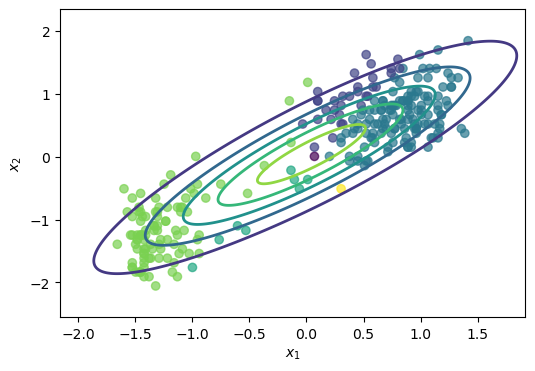

In [11]:
# after one iteration
plot_mixtures(X, gmm_q, step=0.01, levels=5)

### More iterations

We keep updating the parameters using more iterations.

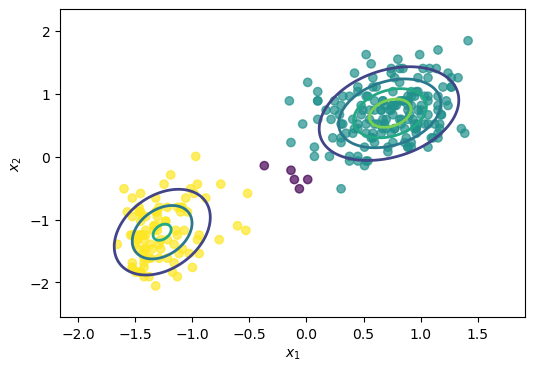

In [12]:
num_iters = 20
for i in range(num_iters):
  gmm_q = update(gmm_q, X)

plot_mixtures(X, gmm_q, step=0.01)

# ELBO monitoring

To monitor the implementation of the Variational GMM, it is useful to compute the lower bound at each step of the the training process. At each step, this bound should not decrease.

Recall the ELBO is defined as:
\begin{aligned}
L[q]
&=\int q(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})\ln\left\{\frac{p(\mathbf{X},\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})}{q(\mathbf{Z}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda})}\right\} \mathrm{d} \boldsymbol{\pi} \mathrm{~d} \boldsymbol{\mu} \mathrm{~d} \boldsymbol{\Lambda} \\
&= \mathbb{E}_{q(\mathbf{Z}) q(\boldsymbol{\mu}, \boldsymbol{\Lambda})}[\ln p(\mathbf{X} \vert \mathbf{Z}, \boldsymbol{\mu}, \boldsymbol{\Lambda})] + \mathbb{E}_{q(\mathbf{Z}) q(\boldsymbol{\pi})}[\ln p(\mathbf{Z} \vert \boldsymbol{\pi})] + \mathbb{E}_{q(\boldsymbol{\pi})}[\ln p(\boldsymbol{\pi})] \\
&\quad + \mathbb{E}_{q(\boldsymbol{\mu, \Lambda})}[\ln p(\boldsymbol{\mu}, \boldsymbol{\Lambda})] - \mathbb{E}_{q(\mathbf{Z})}[\ln q(\mathbf{Z})] - \mathbb{E}_{q(\boldsymbol{\pi})}[\ln q(\boldsymbol{\pi})] - \mathbb{E}_{q(\boldsymbol{\mu, \Lambda})}[\ln q(\boldsymbol{\mu, \Lambda})],
\end{aligned}

where:

\begin{aligned}
E_{1} &= \mathbb{E}_{q(\mathbf{Z})q(\boldsymbol{\mu}, \boldsymbol{\Lambda})}[\ln p(\mathbf{X} \mid \mathbf{Z}, \boldsymbol{\mu}, \boldsymbol{\Lambda})] \\
&= \mathbb{E}_{q(\mathbf{Z})q(\boldsymbol{\mu}, \boldsymbol{\Lambda})}[\sum_{n=1}^{N}\sum_{k=1}^{K} z_{nk} \ln \mathscr{N}(\mathbf{x}_n \mid \mathbf{\mu}_{k}, \Lambda_{k}^{-1})]\\
&= \sum_{n=1}^{N}\sum_{k=1}^{K} \mathbb{E}_{q(z_{nk})q(\mu_k, \mathbf{\Lambda}_k)}\left[z_{nk}\left(\frac{1}{2}\ln|\mathbf{\Lambda}_k| - \frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^{\top}\mathbf{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k) - \frac{D}{2}\ln(2\pi)\right)\right]\\
&= \frac{1}{2} \sum_{n=1}^{N}\sum_{k=1}^{K} r_{nk} \left[ \ln\widetilde{\Lambda}_k - \nu_k(\mathbf{x}_n - \mathbf{m}_k)^\top \mathbf{W}_k(\mathbf{x}_n - \mathbf{m}_k) - D\beta^{-1}_k - D\ln(2\pi) \right] \\
&= \frac{1}{2} \sum_{k=1}^K N_k\left\{\ln \widetilde{\Lambda}_k-D \beta_k^{-1}-\nu_k \operatorname{Tr}\left(\mathbf{S}_k \mathbf{W}_k\right)\right. \left.-\nu_k\left(\boldsymbol{\bar{\mathbf{x}}}_k-\mathbf{m}_k\right)^{\top} \mathbf{W}_k\left(\boldsymbol{\bar{\mathbf{x}}}_k-\mathbf{m}_k\right)-D \ln (2 \pi)\right\},
\end{aligned}

where we use the fact
$$ \mathbb{E}_{q(\boldsymbol{\mu}_k,\boldsymbol{\Lambda}_k)}
\left[(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top\boldsymbol{\Lambda}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\right]
= \nu_k(\mathbf{x}_n - \mathbf{m}_k)^\top \mathbf{W}_k(\mathbf{x}_n - \mathbf{m}_k) + D\beta^{-1}_k ,$$
and the last line uses the fact that
\begin{aligned}
\sum_{n=1}^N r_{nk} \mathbf{x}_n \mathbf{x}_n^{\top} & =\sum_{n=1}^N r_{nk} \left(\mathbf{x}_n-\boldsymbol{\bar{\mathbf{x}}}_k\right)\left(\mathbf{x}_n-\boldsymbol{\bar{\mathbf{x}}}_k\right)^{\top}+N_k \boldsymbol{\bar{\mathbf{x}}}_k \boldsymbol{\bar{\mathbf{x}}}_k^{\mathrm{T}} \\
& =N_k \mathbf{S}_k+N_k \boldsymbol{\bar{\mathbf{x}}}_k \boldsymbol{\bar{\mathbf{x}}}_k^{\top}.
\end{aligned}

#### Question 4 (10 marks)

To complete the ELBO $L[q]$, find the expressions for $\mathbb{E}_{q(\mathbf{Z}) q(\boldsymbol{\pi})}[\ln p(\mathbf{Z} \vert \boldsymbol{\pi})]$, $\mathbb{E}_{q(\boldsymbol{\pi})}[\ln p(\boldsymbol{\pi})]$, 
$\mathbb{E}_{q(\boldsymbol{\mu, \Lambda})}[\ln p(\boldsymbol{\mu}, \boldsymbol{\Lambda})]$, $ \mathbb{E}_{q(\mathbf{Z})}[\ln q(\mathbf{Z})]$, $ \mathbb{E}_{q(\boldsymbol{\pi})}[\ln q(\boldsymbol{\pi})]$, and $ \mathbb{E}_{q(\boldsymbol{\mu, \Lambda})}[\ln q(\boldsymbol{\mu, \Lambda})]$. Write the expressions in latex in the markdown cell below.

_Write the latex expressions here_

#### Question 5 (10 marks)

Write the function that computes the ELBO in the cell below. This function can call additional functions. Please make sure you comment which part of the code computes which part of the ELBO.

In [ ]:
def gmm_elbo(model, X):
    """
    ELBO of the GMM
    """
    
    # Write your code here
    
    return elbo

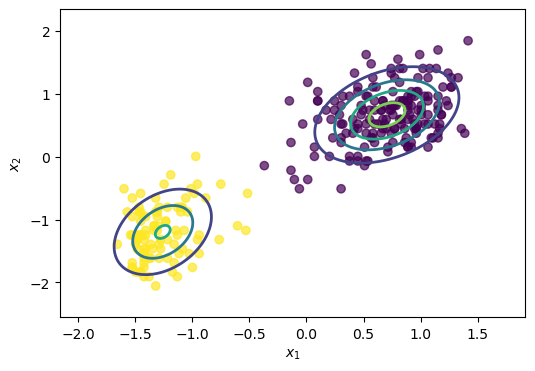

In [19]:
num_iters = 20
elbo_hist = []
for i in range(num_iters):
  gmm_q = update(gmm_q, X)
  elbo = gmm_elbo(gmm_q, X)
  elbo_hist.append(elbo)

plot_mixtures(X, gmm_q, step=0.01)

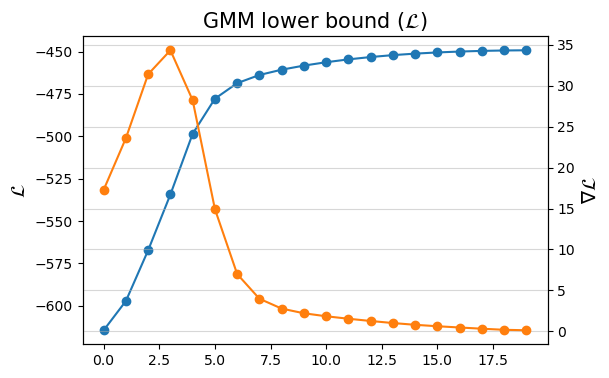

In [20]:
def plot_gmm_elbo(elbo_hist):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    xhist = np.ones_like(elbo_hist).cumsum() - 1
    ax.plot(xhist, elbo_hist, marker="o")
    ax2.plot(xhist, np.gradient(elbo_hist), marker="o", c="tab:orange")
    ax.set_ylabel("$\mathcal{L}$", fontsize=14)
    ax2.set_ylabel(r"$\nabla \mathcal{L}$", fontsize=14)
    ax2.grid(alpha=0.5)
    plt.title(r"GMM lower bound ($\mathcal{L}$)", fontsize=15)
    plt.show()

plot_gmm_elbo(elbo_hist)